#  Email spam classification

   - Get the data from: http://www.andrew.cmu.edu/user/georgech/preprocessed-enron-email-dataset.zip
   - Unzip this into the same folder as this notebook, rename it to `email-data`
   - The folder contains 3 subfolders:
      - `ham` contains ham emails.
      - `spam` contains spam emails.
      - `testing` is a folder containing test emails for your classifier. The ham/spam label is in the filename.
      
**Important**: For this problem, do *not* use neural nets/deep nets.

**(a) Print the number of ham and spam emails [1 point]**

In addition to providing the code, respond to the following questions:

   - Is this dataset imbalanced? Will this be problematic in training the model?
   - If so, how would you address it? (You do *not* have to implement what you suggest here for later parts of the problem.)

In [ ]:
#your code here
import glob
ham_emails=[]
spam_emails=[]

for filepath in glob.iglob('./email-data/ham/*ham.txt'):
    hamfileName=filepath.split("\\")[1]
    ham_emails.append(hamfileName)
    
for filepath in glob.iglob('./email-data/spam/*spam.txt'):
    spamfileName=filepath.split("\\")[1]
    spam_emails.append(spamfileName)
    
    
print("Ham Email Count: ",len(ham_emails))
print("Spam Email Count: ",len(spam_emails))

Ham Email Count:  1500
Spam Email Count:  3671


**Your answers to the above questions:**
1. Technically, yes, the data is imbalanced as the number of spam emails(majority class) is more than the number of ham emails (minority class). This can be considered as a case of severe class imbalance as opposed to a slight imbalance, since the distribution of spam vs ham examples is uneven by a large amount in training dataset. There is a 29(ham)/61(spam) distribution meaning it is highly skewed towards the spam class. (Essentially, only 29% of the training data is ham, while 61% is spam).

This could be problematic/challening in training the model as most classification algorithms work with the underlying assumption that the data is equally distributed across the classes. Using the current distribution would result in a model that shows poor predictive performance for the minority class, ham. If it is more important to not mark a ham email as spam (and this is generally the case), this problem is more sensitive to classification errors. 

2. A good way to circumvent the imbalanced classification problem is to use undersampling where we could use all the ham emails and randomly select the same number of spam emails (as ham emails) several times to make multiple data sets, and then combine all the classification results. This is a good way to avoid losing any information. 

**(b) Construct the documents [4 points]**
 
   - Provided below is a function that returns a document present in a file given a fileName.
   - The function performs some preprocessing to (1) remove punctuation, (2),(3) remove whitespace and (4) lowercase all words.
   - Use this function to construct a list of documents.
   - Also construct a list of document labels containing `1` for spam and `0` for ham.

In [ ]:
import re
import string
import codecs

def makeWordList(path):
    
    with codecs.open(path, "r", encoding='utf-8', errors='ignore') as f:
        corpus_text = f.read()

    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")  # -- (1)
    
    text = re.sub(r'\S*\d\S*','',corpus_text) # -- (2)
    text = re.sub(r'[^\w\s]','',text)         # -- (3)
    
    text = text.lower().split()           # -- (4)         
    
    li = []
    for token in text:
        li.append(token)

    return " ".join(li)

In [ ]:
#your code here
processed_documents=[]
document_labels=[]

for hamfilepath in glob.iglob('./email-data/ham/*ham.txt'):
    processed_documents.append(makeWordList(hamfilepath))
    document_labels.append(0)
    
for spamfilepath in glob.iglob('./email-data/spam/*spam.txt'):
    processed_documents.append(makeWordList(spamfilepath))
    document_labels.append(1)

**(c) Construct the document matrix `X` as a matrix of word frequencies [5 points]**

   - Use the `CountVectorizer` from scikit-learn.
   - Set `min_df=50`; this drops words that don't occur in at least 50 documents.
   - Set `stop_words="english"` and `max_df=0.8` to filter out stop-words.
   - Print the size of the vocabulary (number of unique words)

In [ ]:
#your code here
from sklearn.feature_extraction.text import CountVectorizer

vectorizer=CountVectorizer(max_df=0.8,min_df=50,stop_words='english')

X=vectorizer.fit_transform(processed_documents)

In [ ]:
print("Number of unique words: ",X.shape[1])  #Vocabulary size for the 5171 documents

Number of unique words:  1680


**(d) k-NN and random forest: Hyperparameter selection [10 points]**

Now that you have your documents and labels as training data, you can perform 5-fold cross-validation to select the hyperparameters for different learning algorithms.

The hyperparameter with the best performance averaged across 5 folds is chosen. Use the **weighted F1-score** as the evaluation metric (i.e., for the `f1_score` function imported from `sklearn.metrics`, be sure to use the parameter `average='weighted'`).

   - k-NN: Select `k` from a range of values of your choice.
   - Random forest: Select `max_features` **and** `min_samples_leaf` from a grid of your choice.

Store each chosen hyperparameter as `best_k`, `best_max_features`, and `best_min_samples_leaf` respectively.

Provided is some seed code for cross-validation that you may modify and reuse. Do not use the cross-validations score or grid-search functions from scikit-learn (you may use `KFold`).

In [ ]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import numpy as np

num_folds = 5
k_fold = KFold(num_folds,shuffle=True,random_state=0)
num_features=X.shape[1]
hyperparameter_settings = [(max_features,min_samples_leaf)
                          for max_features in [int(np.ceil(np.sqrt(num_features)/4)),
                                              int(np.ceil(np.sqrt(num_features))),
                                              int(np.ceil(np.sqrt(num_features)*4))]
                           for min_samples_leaf in [1,2,4,8,16]] 

best_hyperparam_setting = None
best_cross_val_score = -np.inf  # assumes that a higher score is better
for hyperparam_setting in hyperparameter_settings:
    max_features, min_samples_leaf=hyperparam_setting
    fold_scores = []
    for proper_train_indices, val_indices in k_fold.split(X.toarray()):
        proper_train_features=X.toarray()[proper_train_indices]
        proper_train_labels=np.array(document_labels)[proper_train_indices]
        val_features=X.toarray()[val_indices]
        val_labels=np.array(document_labels)[val_indices]
        
        
        rf_classifier=RandomForestClassifier(max_features=max_features,min_samples_leaf=min_samples_leaf,
                                         random_state=0)
        rf_classifier.fit(proper_train_features,proper_train_labels)
        predicted_val_labels=rf_classifier.predict(val_features)
        f1score=f1_score(val_labels,predicted_val_labels,average='weighted')
        fold_scores.append(f1score)
    
    cross_val_score = np.mean(fold_scores)
    print('Hyperparameter:', hyperparam_setting, 'cross validation score:', cross_val_score)
    if cross_val_score > best_cross_val_score:  # assumes that a higher score is better
        best_cross_val_score = cross_val_score
        best_hyperparam_setting = hyperparam_setting

print('Best hyperparameter setting:', best_hyperparam_setting)

Hyperparameter: (11, 1) cross validation score: 0.9881461292976711
Hyperparameter: (11, 2) cross validation score: 0.9834165902742077
Hyperparameter: (11, 4) cross validation score: 0.9713043953276259
Hyperparameter: (11, 8) cross validation score: 0.9498031539027915
Hyperparameter: (11, 16) cross validation score: 0.9195216891609774
Hyperparameter: (41, 1) cross validation score: 0.988568013213186
Hyperparameter: (41, 2) cross validation score: 0.9840407496716704
Hyperparameter: (41, 4) cross validation score: 0.9814661063271863
Hyperparameter: (41, 8) cross validation score: 0.9737394649254723
Hyperparameter: (41, 16) cross validation score: 0.9626759501851767
Hyperparameter: (164, 1) cross validation score: 0.9798744467984735
Hyperparameter: (164, 2) cross validation score: 0.9796281404172689
Hyperparameter: (164, 4) cross validation score: 0.9756366990425047
Hyperparameter: (164, 8) cross validation score: 0.9707016974403787
Hyperparameter: (164, 16) cross validation score: 0.96272

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

best_k=None
best_cross_val_score = -np.inf  # assumes that a higher score is better

for k in 2**np.arange(0,11):
    knn_fold_scores=[]
    
    for proper_train_indices, val_indices in k_fold.split(X.toarray()):
        proper_train_features=X.toarray()[proper_train_indices]
        proper_train_labels=np.array(document_labels)[proper_train_indices]
        val_features=X.toarray()[val_indices]
        val_labels=np.array(document_labels)[val_indices]
    
        classifier=KNeighborsClassifier(n_neighbors=k)
        classifier.fit(proper_train_features,proper_train_labels)
        knn_predicted_val_labels=classifier.predict(val_features)
        knn_f1score=f1_score(val_labels,knn_predicted_val_labels,average='weighted')
        knn_fold_scores.append(knn_f1score)
    
    knn_cross_val_score=np.mean(knn_fold_scores)
    print('k:', k, 'cross validation score:', knn_cross_val_score)
    
    if knn_cross_val_score > best_cross_val_score:  # assumes that a higher score is better
        best_cross_val_score = knn_cross_val_score
        best_k=k

print('Best k:', best_k, 'cross validation score:', best_cross_val_score)

k: 1 cross validation score: 0.9390623609919132
k: 2 cross validation score: 0.9269690936582229
k: 4 cross validation score: 0.9439985653337788
k: 8 cross validation score: 0.9211335942514947
k: 16 cross validation score: 0.8936872160575631
k: 32 cross validation score: 0.8514700866035628
k: 64 cross validation score: 0.8248876683277064
k: 128 cross validation score: 0.7879986700117027
k: 256 cross validation score: 0.7527813281213498
k: 512 cross validation score: 0.7172745903119837
k: 1024 cross validation score: 0.65665615316079
Best k: 4 cross validation score: 0.9439985653337788


**(e) Classifier testing: Precision-Recall and ROC curves [10 points]**

   - Use the best hyperparameters for each classifier from the previous question to **train** your classifiers on the full training data.
   - Use test emails in the `testing` folder to **test** your classifiers and construct the plots below.

Things to plot:

   - Construct one plot containing 2 ROC curves, one for each classifier. (We vary the threshold probability of declaring an email to be spam to obtain these plots.)
   - In the legend of this plot, display the AUC for each classifier.
   - Construct one plot containing 2 precision-recall curves, one for each classifier.
   - In the legend of each plot, display the average precision for each classifier using the sklearn function [`average_precision_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score); average precision is essentially an approximation of the area under the precision-recall curve that avoids being overly optimistic.

Note that these plots are on the test data: you will have to read in this data, construct a document matrix and labels. Some words in the test data may not have been present in the training data: there are multiple ways to address this, briefly describe your approach.

Things to answer:

   - Of the ROC and Precision-Recall curves, which one would you use for this task and why?
   - Which classifier is the best, according to your chosen curves?

In [ ]:
#your code here
test_emails=[]
test_labels=[]

for hamemails in glob.iglob('./email-data/testing/*ham.txt'):
    test_emails.append(makeWordList(hamemails))
    test_labels.append(0)
    
for spamemails in glob.iglob('./email-data/testing/*spam.txt'):
    test_emails.append(makeWordList(spamemails))
    test_labels.append(1)
    
Y=vectorizer.transform(test_emails)

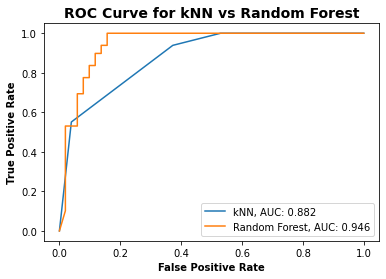

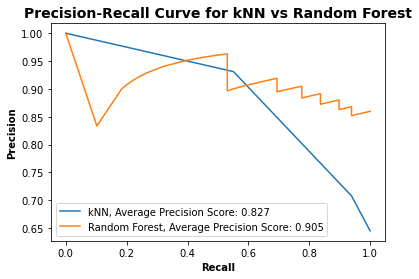

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt

final_knn_classifier=KNeighborsClassifier(n_neighbors=best_k)
final_knn_classifier.fit(X.toarray(),np.array(document_labels))
knn_predicted_test_probs=final_knn_classifier.predict_proba(Y.toarray())[:,1]


best_max_features, best_min_samples_leaf = best_hyperparam_setting
final_rf_classifier = RandomForestClassifier(max_features=best_max_features,
                                             min_samples_leaf=best_min_samples_leaf,
                                             random_state=0)
final_rf_classifier.fit(X.toarray(), np.array(document_labels))
rf_predicted_test_probs = final_rf_classifier.predict_proba(Y.toarray())[:,1]


knn_false_positive_rate, knn_true_positive_rate, knn_threshold = roc_curve(test_labels,knn_predicted_test_probs)
rf_false_positive_rate, rf_true_positive_rate, rf_threshold = roc_curve(test_labels,rf_predicted_test_probs)

knn_roc_auc=roc_auc_score(test_labels,knn_predicted_test_probs)
rf_roc_auc=roc_auc_score(test_labels,rf_predicted_test_probs)

plt.subplots(1)
plt.plot(knn_false_positive_rate,knn_true_positive_rate,label=("kNN, AUC: {0:.3f}".format(knn_roc_auc)))
plt.plot(rf_false_positive_rate,rf_true_positive_rate,label=("Random Forest, AUC: {0:.3f}".format(rf_roc_auc)))
plt.legend(fontsize='medium')
plt.ylabel('True Positive Rate',fontweight ='bold', fontsize = 10)
plt.xlabel('False Positive Rate',fontweight ='bold', fontsize = 10)
plt.title('ROC Curve for kNN vs Random Forest',fontweight ='bold', fontsize = 14)
plt.show()



knn_precision, knn_recall, knn_thresholds=precision_recall_curve(test_labels,knn_predicted_test_probs)
rf_precision,rf_recall,rf_thresholds=precision_recall_curve(test_labels,rf_predicted_test_probs)

knn_avg_precision_score=average_precision_score(test_labels,knn_predicted_test_probs)
rf_avg_precision_score=average_precision_score(test_labels,rf_predicted_test_probs)

plt.subplots(1)
plt.plot(knn_recall,knn_precision,label=("kNN, Average Precision Score: {0:.3f}".format(knn_avg_precision_score)))
plt.plot(rf_recall,rf_precision,label=("Random Forest, Average Precision Score: {0:.3f}".format(rf_avg_precision_score)))
plt.legend(fontsize='medium')
plt.ylabel('Precision',fontweight ='bold', fontsize = 10)
plt.xlabel('Recall',fontweight ='bold', fontsize = 10)
plt.title('Precision-Recall Curve for kNN vs Random Forest',fontweight ='bold', fontsize = 14)
plt.show()

## **Your answers to the above questions:**
1. Since the training and testing text/vocabulary is different, we shouldn't use fit_transform() on test-dataset. We should only use the vocabulary that has been learned from the train-dataset. By using transform() on the test data, we only consider the vocabulary learned from train-corpus, thereby ignoring any new words found in test-set.

2. The Precision-Recall Curve would be better-suited for this task because of the data imbalance in the training set. (ROC curves can present an overly optimistic view of an algorithm’s performance if there is a large skew in the class distribution (which is true in our training dataset).The ROC Plot for imbalanced datasets can be visually deceptive due to the misleading interpreration of the False Positive Rate.
Precision-Recall curves on the hand, provide a more reliable picture of future classification performance, since they evaluate the fraction of positive predictions amongst the true positives.

(Source referred to for answer 2: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4349800/)

3. Accoridng to my chosen curve - which is Precision-Recall curve, the Random Forest classifier is better as its Average Precision Score is higher (0.905 vs 0.827 for kNN). Even if we consider the ROC curve, Random Forest performs better as the Area under the Curve for Random Forest is higher (0.946 vs 0.882 for kNN). Average Precision Score is a significant evaluation metric in this case as it would be more important to not mark a ham email as spam!)

# Part 2: Representation Learning [40 points]

Before getting started, please put the attached file `pretrained_convnet.pt` in the same directory as this notebook.

Recall from lecture the "crumpled paper analogy": in a neural net, as you progress through the layers from input to output, the layers should be "unfolding the original space" to disentangle the classes. When you get to the layer before the classifier, you should've changed the data representation into something that makes classification easy. **We will refer to the layer before the classifier in the neural net as the bottleneck layer.**

In this problem, you will be using an output of a bottleneck layer from pre-trained CNN as input features for a few simple classifiers. The CNN provided was trained with the Fashion MNIST dataset which consists of 10 classes of 28x28 grayscale images; this dataset is very similar to MNIST in that there are 10 classes with images that are the same size as MNIST and in fact even the training and test set sizes are the same (60,000 and 10,000 respectively). However, the classes are not the digits 0 through 9. Instead the classes are:

| Class | Description |
| ----- | :---------: |
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

Let's start with some imports.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchsummaryX import summary

from UDA_pytorch_utils import UDA_pytorch_classifier_fit, \
        UDA_plot_train_val_accuracy_vs_epoch, UDA_pytorch_classifier_predict, \
        UDA_pytorch_model_transform, UDA_compute_accuracy

**Loading in the data.** We first load the Fashion MNIST dataset and plot some example images.

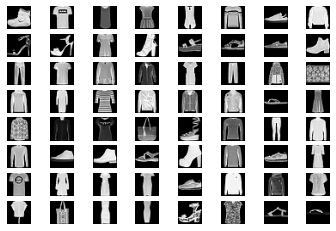

In [ ]:

train_dataset = torchvision.datasets.FashionMNIST(root='data/',
                                                  train=True,
                                                  transform=transforms.ToTensor(),
                                                  download=True)

train_images = torch.tensor([image.numpy() for image, label in train_dataset])
train_labels = torch.tensor([label for image, label in train_dataset])

test_dataset = torchvision.datasets.FashionMNIST(root='data/',
                                                 train=False,
                                                 transform=transforms.ToTensor(),
                                                 download=True)

test_images = torch.tensor([image.numpy() for image, label in test_dataset])
test_labels = torch.tensor([label for image, label in test_dataset])

# show some of the first training images
square_grid_num_rows = 8
num_images_to_show = square_grid_num_rows ** 2
for idx in range(num_images_to_show):
    plt.subplot(square_grid_num_rows, square_grid_num_rows, idx + 1)
    plt.imshow(train_images[idx][0], cmap='gray')
    plt.axis('off')

**(a) [5 points]** Select train and test data that belong to classes 2 (corresponding to pullovers) or 6 (corresponding to fancier shirts than t-shirts; note: class 0 corresponds to t-shirts), i.e., subsample all the data that has label 2 or 6. Save the variables as `x_train`, `x_test`, `y_train`, `y_test`. From now on, we are only dealing with the images that are in classes 2 (pullovers) or 6 (shirts). Moreover, in `y_train` and `y_test`, please renumber the two classes so that pullovers now instead corresponds to 0 and shirts corresponds to 1 (we will consider shirts to be the "positive" class and pullovers to be the "negative" class).

In [ ]:
train_images_array=np.array(train_images)
train_labels_array=np.array(train_labels)

x_train=[]
y_train=[]

for i,label in enumerate(train_labels_array):
    if label==2:
        x_train.append(train_images_array[i])
        y_train.append(0)
    elif(label==6):
        x_train.append(train_images_array[i])
        y_train.append(1)
        
test_images_array=np.array(test_images)
test_labels_array=np.array(test_labels)

x_test=[]
y_test=[]

for index,lbl in enumerate(test_labels_array):
    if lbl==2:
        x_test.append(test_images_array[index])
        y_test.append(0)
    elif lbl==6:
        x_test.append(test_images_array[index])
        y_test.append(1)
        
x_train=np.array(x_train)
y_train=np.array(y_train)
x_test=np.array(x_test)
y_test=np.array(y_test)

In [ ]:

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(12000, 1, 28, 28) (12000,)
(2000, 1, 28, 28) (2000,)


We will make some t-SNE visualizations shortly and using all the training data will be too slow. We reduce the size of the training dataset by randomly subsampling 1000 samples from `x_train`/`y_train` pairs and saving the subsampled versions as `x_train_small`/`y_train_small` (the i-th image in `x_train_small` should have its label given by the i-th entry in `y_train_small`). We have provided the indices of which 1000 samples to use (from within `x_train`/`y_train`).

In [ ]:

np.random.seed(0)
random_sample = np.random.permutation(len(x_train))[:1000]

In [ ]:

x_train_small=x_train[random_sample]
y_train_small=y_train[random_sample]

**(b) [9 points]** We are ready to load the pre-trained convnet. The bottleneck layer is right before the final linear layer and corresponds to the output of a ReLU that has 84 values. **We refer to the output of this ReLU as the bottleneck feature vector representation of whatever the input is.**

Note that the convnet was pre-trained using the entire training dataset which consists of 60,000 samples and all 10 labels.

In [ ]:
# load the pre-trained CNN
convnet = nn.Sequential(nn.Conv2d(1, 6, 3),
                        nn.ReLU(),
                        nn.MaxPool2d(2),
                        nn.Conv2d(6, 16, 3),
                        nn.ReLU(),
                        nn.MaxPool2d(2),
                        nn.Flatten(),
                        nn.Linear(in_features=16 * 5 * 5, out_features=120),
                        nn.ReLU(),
                        nn.Linear(in_features=120, out_features=84),
                        nn.ReLU(),
                        nn.Linear(in_features=84, out_features=10))
convnet.load_state_dict(torch.load('pretrained_convnet.pt',map_location=torch.device('cpu')))
convnet.eval()
print('[Summary of pre-trained convnet]')
summary(convnet, torch.zeros((1, 1, 28, 28)))
print()

# select the pretrained CNN upto the bottleneck layer
intermediate_layer_model = convnet[:-1]
print('[Summary of the pre-trained convnet up to the bottleneck layer]')
summary(intermediate_layer_model, torch.zeros((1, 1, 28, 28)))

[Summary of pre-trained convnet]
        Kernel Shape     Output Shape   Params Mult-Adds
Layer                                                   
0_0     [1, 6, 3, 3]   [1, 6, 26, 26]     60.0   36.504k
1_1                -   [1, 6, 26, 26]        -         -
2_2                -   [1, 6, 13, 13]        -         -
3_3    [6, 16, 3, 3]  [1, 16, 11, 11]    880.0  104.544k
4_4                -  [1, 16, 11, 11]        -         -
5_5                -    [1, 16, 5, 5]        -         -
6_6                -         [1, 400]        -         -
7_7       [400, 120]         [1, 120]   48.12k     48.0k
8_8                -         [1, 120]        -         -
9_9        [120, 84]          [1, 84]  10.164k    10.08k
10_10              -          [1, 84]        -         -
11_11       [84, 10]          [1, 10]    850.0     840.0
---------------------------------------------------------
                        Totals
Total params           60.074k
Trainable params       60.074k
Non-trainable para

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_0,"[1, 6, 3, 3]","[1, 6, 26, 26]",60.0,36504.0
1_1,-,"[1, 6, 26, 26]",NaN,NaN
2_2,-,"[1, 6, 13, 13]",NaN,NaN
3_3,"[6, 16, 3, 3]","[1, 16, 11, 11]",880.0,104544.0
4_4,-,"[1, 16, 11, 11]",NaN,NaN
5_5,-,"[1, 16, 5, 5]",NaN,NaN
6_6,-,"[1, 400]",NaN,NaN
7_7,"[400, 120]","[1, 120]",48120.0,48000.0
8_8,-,"[1, 120]",NaN,NaN


We first extract bottleneck feature vectors of the subsampled 1000 training data from the intermediate model.

In [ ]:

x_train_small_bottleneck_representation = UDA_pytorch_model_transform(intermediate_layer_model, x_train_small)

Next, visualize two different types of features with t-SNE.

1. Make a t-SNE plot using the **784 (=28$\times$28) dimensional raw features** from the subsampled training data (i.e., using `x_train_small`). Set `n_components=2, verbose=1, perplexity=25, random_state=0` for `TSNE` from scikit-learn. Plot the two classes in different colors.

2. Repeat the previous step (using the exact same arguments for `TSNE`) except now using the **84 dimensional bottleneck features** (i.e., using `x_train_small_bottleneck_representation`.

You may need to convert between PyTorch tensors and NumPy arrays.

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.288s...
[t-SNE] Computed neighbors for 1000 samples in 2.480s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 1.929498
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.154922
[t-SNE] KL divergence after 1000 iterations: 1.066527
[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.038s...
[t-SNE] Computed neighbors for 1000 samples in 0.268s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.053075
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.024734
[t-SNE] KL divergence after 1000 iterations: 0.988291


Text(0.5, 1.0, '84 Dimensional Bottleneck Features t-SNE Plot')

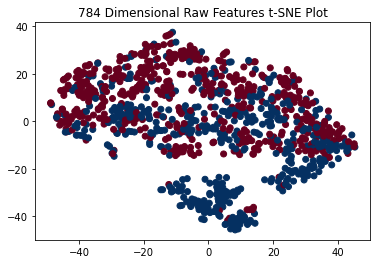

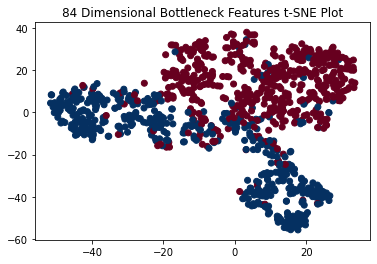

In [ ]:

from sklearn.manifold import TSNE

plt.subplots(1)
tsne = TSNE(n_components=2, verbose=1, perplexity=25, random_state=0)
feature_vectors_tsne2d = tsne.fit_transform(x_train_small.reshape(x_train_small.shape[0],-1))
plt.scatter(feature_vectors_tsne2d[:,0],feature_vectors_tsne2d[:,1],c=y_train_small,cmap='RdBu')
plt.title("784 Dimensional Raw Features t-SNE Plot")

plt.subplots(1)
tsne_bottleneck=TSNE(n_components=2, verbose=1, perplexity=25, random_state=0)
bottleneck_fv=tsne_bottleneck.fit_transform(np.array(x_train_small_bottleneck_representation))
plt.scatter(bottleneck_fv[:,0],bottleneck_fv[:,1],c=y_train_small,cmap='RdBu')
plt.title("84 Dimensional Bottleneck Features t-SNE Plot")

**(c) [16 points]** We now evaluate on test data and compare several different classifiers. Train **5-NN** and **random forest** classifiers with **784 (=28$\times$28) raw features** and, separately, the **84 bottleneck features** from **all training data**, respectively. That means you should train 4 models in total:

1. 5-NN classifier trained on all raw training features
2. 5-NN classifier trained on all training bottleneck features
3. Random forest trained on all raw training features (for reproducibility of code, please use arguments `n_estimators=100, random_state=0` for `RandomForestClassifier`)
4. Random forest trained on all training bottleneck features (again, use `n_estimators=100, random_state=0`)

Test each model with corresponding **test dataset** and print the test accuracy. Also, compute and print the test accuracy of the **pre-trained convnet** (`convnet`) by using **test data**. You may think of this task as filling in the blanks of the following table with test accuracy results.

| Model type       | Raw features        | Bottleneck features  |
|:---------------- |:-------------------:|:--------------------:|
| Pretrained CNN   | 0.891               |                      |
| 5-NN             | 0.8560              | 0.888                |
| Random forest    | 0.8765              | 0.898                |

Important: the pre-trained convnet is for all 10 classes; only look at the probabilities corresponding to pullovers (class 2) and shirts (class 6), and take an argmax only over these two class probabilities to come up with predictions stricted to pullovers or shirts.

In [ ]:

from sklearn.neighbors import KNeighborsClassifier

x_train_bottleneck_representation = UDA_pytorch_model_transform(intermediate_layer_model, x_train)
x_test_bottleneck_representation = UDA_pytorch_model_transform(intermediate_layer_model, x_test)


raw_5NN_classifier = KNeighborsClassifier(n_neighbors=5)
raw_5NN_classifier.fit(x_train.reshape(x_train.shape[0],-1), y_train)
raw_5nn_predicted_test_labels=raw_5NN_classifier.predict(x_test.reshape(x_test.shape[0],-1))
raw_5nn_test_error=np.mean(raw_5nn_predicted_test_labels!=y_test)
raw_5nn_test_accuracy=1-raw_5nn_test_error
print("5-NN Raw Features Accuracy: ",raw_5nn_test_accuracy)

bottleneck_5nn_classifier=KNeighborsClassifier(n_neighbors=5)
bottleneck_5nn_classifier.fit(x_train_bottleneck_representation,y_train)
bottleneck_5nn_predicted_test_labels=bottleneck_5nn_classifier.predict(x_test_bottleneck_representation)
bottleneck_5nn_test_error=np.mean(bottleneck_5nn_predicted_test_labels!=y_test)
bottleneck_5nn_test_accuracy=1-bottleneck_5nn_test_error
print("5-NN Bottleneck Features Accuracy: ",bottleneck_5nn_test_accuracy)


from sklearn.ensemble import RandomForestClassifier
raw_rf_classifier = RandomForestClassifier(n_estimators=100,max_features='auto', min_samples_leaf=1, random_state=0)
raw_rf_classifier.fit(x_train.reshape(x_train.shape[0],-1), y_train)
raw_rf_predicted_test_labels=raw_rf_classifier.predict(x_test.reshape(x_test.shape[0],-1))
raw_rf_test_error=np.mean(raw_rf_predicted_test_labels!=y_test)
raw_rf_test_accuracy=1-raw_rf_test_error
print("Random Forest Raw Features Accuracy: ",raw_rf_test_accuracy)

bottleneck_rf_classifier=RandomForestClassifier(n_estimators=100,max_features='auto', min_samples_leaf=1, random_state=0)
bottleneck_rf_classifier.fit(x_train_bottleneck_representation,y_train)
bottleneck_rf_predicted_test_labels=bottleneck_rf_classifier.predict(x_test_bottleneck_representation)
bottleneck_rf_test_error=np.mean(bottleneck_rf_predicted_test_labels!=y_test)
bottleneck_rf_test_accuracy=1-bottleneck_rf_test_error
print("Random Forest Bottleneck Features Accuracy: ", bottleneck_rf_test_accuracy)


x_test_pretrained_representation = UDA_pytorch_model_transform(convnet, x_test)
test_convnet_labels=np.argmax(x_test_pretrained_representation[:,[2,6]],axis=1)
pretrained_convnet_test_error=np.mean(np.array(test_convnet_labels)!=y_test)
pretrained_convnet_test_accuracy=1-pretrained_convnet_test_error

print('Pre-trained CNN Raw Features Accuracy: ', pretrained_convnet_test_accuracy)

5-NN Raw Features Accuracy:  0.856
5-NN Bottleneck Features Accuracy:  0.888
Random Forest Raw Features Accuracy:  0.8765000000000001
Random Forest Bottleneck Features Accuracy:  0.898
Pre-trained CNN Raw Features Accuracy:  0.891


Among the five models above, which model performed the best? Which model showed the lowest accuracy? For the 1-NN and random forest classifiers, is the prediction accuracy higher using bottleneck features instead of the raw features?

**Write your answers here:**

Among the five models above, Random forest trained on all training bottleneck features performed the best as its accuracy is the highest (0.898).

The lowest accuracy was shown by the 5-NN classifier trained on all raw training features.

For the 5-NN and Random Forest classifiers, the prediction accuracy is higher using the bottleneck features instead of the raw features!

**(d) [10 points]** We now look at plotting an ROC curve, varying $k$ in $k$-NN. Train k-NN classifiers with $k=1,2,...,50$ with **bottleneck** feature vectors of all **training** data. As a result, you will get 50 classifiers. Draw a scatter plot that has false positive rate (FPR) on x-axis and true positive rate (TPR) on y-axis. Each scatter point represents one k-NN classifier. Use the **test** data to compute FPR and TPR.

Recall that true and false positive rate calculations require you to specify one of the two outcomes as the "positive" class and the other as the "negative" class. For this problem, use class 6 (shirts) as the "positive" class, and class 2 (pullovers) as the "negative" class.

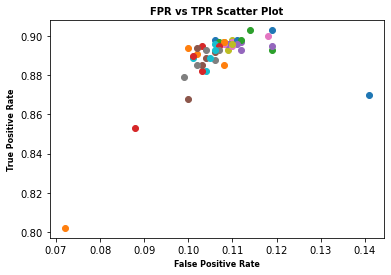

In [ ]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

highest_TPR=-np.inf
best_k=None

for i in range(1,51):
    i_classifier=KNeighborsClassifier(n_neighbors=i)
    i_classifier.fit(x_train_bottleneck_representation,y_train)
    i_predicted_test_probs=i_classifier.predict(x_test_bottleneck_representation)
    i_matrix=confusion_matrix(y_test,i_predicted_test_probs)
    i_TPR=i_matrix[1,1]/(i_matrix[1,1]+i_matrix[1,0])
    i_FPR=i_matrix[0,1]/(i_matrix[0,1]+i_matrix[0,0])
    if((i_TPR>highest_TPR) & (i_FPR<=0.125)):
        highest_TPR=i_TPR
        best_k=i
    
    plt.scatter(i_FPR,i_TPR)
    plt.title('FPR vs TPR Scatter Plot',fontweight ='bold', fontsize = 10)
    plt.xlabel('False Positive Rate',fontweight ='bold', fontsize = 8)
    plt.ylabel('True Positive Rate',fontweight ='bold', fontsize = 8)

Suppose you work for a company that wants to figure out when a shirt appears among photos that have either shirts or pullovers. The company tells you that it cannot tolerate a false positive rate of detecting shirts that is more than 12.5%. What value of number of nearest neighbors $k$ achieves the highest true positive rate, but doesn't have more than a 12.5% false positive rate?

**Write your answer here:** k=11 (TPR=90.3%)

The code above considers the best_k to be the value of number of nearest neighbours k which achieves the highest TPR while the FPR stays <12.5%.
As evident from the code block below, 11 (k=11) nearest neighbours achieves the highest True Positive Rate of 90.3%

In [ ]:

print("value of number of nearest neighbors  𝑘  achieves the highest true positive rate (while FPR < 12.5%) : ",best_k)
print("True Positive Rate for corresponding k: ",highest_TPR)

value of number of nearest neighbors  𝑘  achieves the highest true positive rate (while FPR < 12.5%) :  11
True Positive Rate for corresponding k:  0.903


# Part 3: Sentiment Analysis [40 points]

Download data from: http://www.andrew.cmu.edu/user/georgech/HW3-data.zip <br>

The folder contains:

- `train.csv`
- `test.csv`

In this problem, we look at predicting whether a tweet has positive or negative sentiment.

**We intentionally wrote this problem to be a bit open-ended to let you play with different neural net code yourself and also for you to compare against a classical baseline.** We will give full credit even if you subsample the training data. For example, you only work with 5000 randomly chosen training tweets instead of all of them (over 1 million tweets). Also, for the random forest part (the last part), you can keep track of only the most frequently occurring 1000 words (again, this is enough for full credit) and you can also set the RandomForestClassifier argument "n_jobs" to -1 to use all your CPU threads. However, do not subsample the test dataset (which is small anyways).

If you want to have practice with what it's like working with a sizable dataset though, we do encourage you to try to use as much of the training data as possible (our solution code uses the full training data in an 80-20 split between a proper training set and a validation set, just like in lectures). Note that using all the data does involve more careful data preprocessing to avoid possible memory issues. Some suggestions:

- Using your knowledge from weeks 1 and 2, you can write your own code to tokenize tweets and only include some of the tokens (e.g., only keeping the most common 1000 tokens, etc); in particular you can build your own vocabulary. As a suggestion, make vocabulary token \#0 correspond to a special padding character `"<pad>"`; this special index 0 will in fact be automatically added by the batching process for recurrent neural nets when making different tweets within the same batch have the same length. As another suggestion, make a special vocabulary token `"<unk>"` for unknown tokens that you've decided not to keep track of. For example, if you only keep track of the most common 1000 tokens, then any token that is not one of these most common 1000 gets represented as `"<unk>"`.

- For the last part, training a random forest for sentiment analysis could be very computationally expensive. If you are already subsampling the training data beforehand, then great, just work with a smaller dataset (note: you should use the same training data for both the LSTM and for the random forest so that the comparison between them is fair). If you want to still try to use the full training dataset or as much of it as possible, then we suggest that you represent the feature vectors as a sparse matrix. You might also want to set the "max_samples" argument to be something like 0.1 so that each tree uses a 10% subsample of the proper training set (with the default choice of 100 trees, across all your trees, you will likely use the vast majority of the full training set---it's just that each tree won't look at more than 10% of the proper training set). Also, simple data splitting suffices; cross-validation here would be very expensive. Moreover, it's fine to not train a random forest from scratch using the best hyperparameters found; instead just use whichever model was trained using the proper training data with the best hyperparameters found.

**(a) [5 points]** We first read in the tweet data. Read the data present in `train.csv` file. **Please do not change the filename. In particular, use a relative path, i.e., `./HW3-data/train.csv`**. Then do the following:

1. Keep only the sentiment and sentiment text in the data - the first and the last coumn
2. Print the number of positive and negative sentiment labels

Note: If you are using `open()`, you may have to set `encoding='iso8859'`.

In [ ]:

import pandas as pd
import numpy as np

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

from UDA_pytorch_utils import UDA_pytorch_classifier_fit, \
        UDA_plot_train_val_accuracy_vs_epoch, UDA_pytorch_classifier_predict, \
        UDA_pytorch_model_transform, UDA_compute_accuracy

df=pd.read_csv('./HW3-data/train.csv', header=None, usecols=[0,5],encoding='iso8859')

all_train_labels=np.array(df[0].tolist()) #storing the sentiments in the training data
all_train_tweets=np.array(df[5].tolist()) #storing the tweets

In [ ]:
np.random.seed(0)
random_sample=np.random.permutation(len(all_train_labels))[:30000]

train_labels=all_train_labels[random_sample]
train_tweets=all_train_tweets[random_sample]

print("Number of Positive Sentiment Labels: ",train_labels.tolist().count(1))
print("Number of Negative Sentiment Labels: ",train_labels.tolist().count(0))

Number of Positive Sentiment Labels:  15039
Number of Negative Sentiment Labels:  14961


**(b) [25 points]** Modify the LSTM demo code from lecture to work with this Twitter dataset. Play with the learning rate and batch size so that the training gives reasonable increases in training and validation accuracies as we progress through epochs (leave the number of epochs at 10). Also feel free to try different neural net architectures (although you do not have to). What test accuracy are you able to achieve?

In [ ]:

from torchnlp.encoders.text import SpacyEncoder
import spacy
import torch
import torch.nn as nn
from torchsummaryX import summary

all_train_tweets_labels=list(zip(train_labels.tolist(),train_tweets.tolist()))

proper_train_tweet_size = int(len(train_labels) * 0.8)
val_size = len(train_labels) - proper_train_tweet_size

proper_train_tweets_dataset, val_dataset = torch.utils.data.random_split(all_train_tweets_labels,
                                                                  [proper_train_tweet_size,
                                                                   val_size])

In [ ]:
nlp = spacy.load("en_core_web_sm")
encoder = SpacyEncoder([tweet[1] for tweet in proper_train_tweets_dataset])

In [ ]:
proper_train_tweets_encoded=[encoder.encode(tweet[1]) for tweet in proper_train_tweets_dataset]

In [ ]:
proper_train_tweets_encoded[0]

tensor([5, 6])

In [ ]:
proper_train_tweets_dataset[0]
#Loading the actual tweet in the training dataset

(1, 'follow mehh ')

In [ ]:
print([encoder.vocab[word_idx] for word_idx in proper_train_tweets_encoded[0]])
 #Just verifying the encoded vocabulary with the original tweet

['follow', 'mehh']


In [ ]:
import torch
import torch.nn as nn
from torchsummaryX import summary

proper_train_labels=torch.tensor([label[0] for label in proper_train_tweets_dataset])

In [ ]:
val_encoded=[encoder.encode(data[1]) for data in val_dataset]

In [ ]:
val_labels=torch.tensor([val_label[0] for val_label in val_dataset])

In [ ]:
proper_train_encoded_and_labels=list(zip(proper_train_tweets_encoded,proper_train_labels))
val_dataset_encoded_and_labels=list(zip(val_encoded,val_labels))

In [ ]:
from torchnlp.word_to_vector import GloVe
pretrained_embedding = GloVe(name='6B', dim=100)

In [ ]:
embedding_weights=torch.Tensor(encoder.vocab_size,pretrained_embedding.dim)

for i,token in enumerate(encoder.vocab):
    embedding_weights[i]=pretrained_embedding[token]

In [ ]:
from UDA_pytorch_utils import UDA_LSTMforSequential

simple_lstm_model=nn.Sequential(nn.Embedding.from_pretrained(embedding_weights),
                               UDA_LSTMforSequential(100,64),
                               nn.Linear(64,2))

In [ ]:
summary(simple_lstm_model, torch.zeros((1, 5), dtype=torch.long))

                Kernel Shape Output Shape   Params Mult-Adds
Layer                                                       
0_0             [100, 42660]  [1, 5, 100]        -         -
1_1.LSTM_model             -   [1, 5, 64]  42.496k   41.984k
2_2                  [64, 2]       [1, 2]    130.0     128.0
-------------------------------------------------------------
                         Totals
Total params          4.308626M
Trainable params        42.626k
Non-trainable params     4.266M
Mult-Adds               42.112k


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_0,"[100, 42660]","[1, 5, 100]",NaN,NaN
1_1.LSTM_model,-,"[1, 5, 64]",42496.0,41984.0
2_2,"[64, 2]","[1, 2]",130.0,128.0


Epoch 1 [==================================================] 24000/24000
  Train accuracy: 0.5352
  Validation accuracy: 0.5305
Epoch 2 [==================================================] 24000/24000
  Train accuracy: 0.5344
  Validation accuracy: 0.5130
Epoch 3 [==================================================] 24000/24000
  Train accuracy: 0.5818
  Validation accuracy: 0.5672
Epoch 4 [==================================================] 24000/24000
  Train accuracy: 0.5917
  Validation accuracy: 0.5732
Epoch 5 [==================================================] 24000/24000
  Train accuracy: 0.5259
  Validation accuracy: 0.5113
Epoch 6 [==================================================] 24000/24000
  Train accuracy: 0.7104
  Validation accuracy: 0.6753
Epoch 7 [==================================================] 24000/24000
  Train accuracy: 0.5804
  Validation accuracy: 0.5688
Epoch 8 [==================================================] 24000/24000
  Train accuracy: 0.5695
  Vali

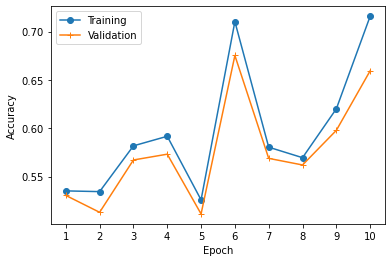

In [ ]:
num_epochs = 10  
batch_size = 64
learning_rate = 0.022

train_accuracies, val_accuracies= UDA_pytorch_classifier_fit(simple_lstm_model,
                                                             torch.optim.Adam(simple_lstm_model.parameters(),
                                                                             lr=learning_rate),
                                                            nn.CrossEntropyLoss(),
                                                            proper_train_encoded_and_labels,val_dataset_encoded_and_labels,
                                                            num_epochs,batch_size,
                                                            sequence=True)
UDA_plot_train_val_accuracy_vs_epoch(train_accuracies, val_accuracies)

In [ ]:
df_test=pd.read_csv('./HW3-data/test.csv', header=None, usecols=[0,5],encoding='iso8859')

test_labels=np.array(df_test[0].tolist()) #storing the sentiments in the training data
test_tweets=np.array(df_test[5].tolist()) #storing the tweets

test_dataset=list(zip(test_labels.tolist(),test_tweets.tolist()))

In [ ]:
test_encoded=[encoder.encode(test_data[1]) for test_data in test_dataset]

In [ ]:
test_labels=torch.tensor([test_lbl[0] for test_lbl in test_dataset])

In [ ]:
predicted_test_labels = UDA_pytorch_classifier_predict(simple_lstm_model,
                                                       test_encoded,
                                                       sequence=True)

In [ ]:
print('Test accuracy:', UDA_compute_accuracy(predicted_test_labels, test_labels))

Test accuracy: 0.5943775100401606


**(c) [10 points]** How well does an LSTM compare with using a classical classifier? To investigate this question, let's try training a random forest for sentiment analysis. Your code from part **(b)** should involve coming up with encoded representations of text, i.e., representing a tweet using a sequence of word indices. Use this to come up with a term frequency representation for each tweet. Feel free to remove stop words and/or apply TF-IDF weighting, and then feed the resulting feature vector representations for tweets to a random forest classifier. You can use cross-validation to select hyperparameters. Try to make the random forest classifier perform as well as possible (it is good practice in real-world applications to try to make baselines as good as possible rather than intentionally using a baseline with lousy hyperparameter choices; in particular, it is *bad* practice to tune hyperparameters carefully only on a method you're proposing while not tuning hyperparameters on baselines!). What test set accuracy are you able to achieve with the random forest?

In [ ]:

from sklearn.ensemble import RandomForestClassifier

rf_train_tweets=[]
rf_train_labels=[]

#Making sure I use the exact same split/distribution of the training and validation data
#as was used for the LSTM model
for label,tweet in proper_train_tweets_dataset:
    rf_train_tweets.append(tweet)
    rf_train_labels.append(label)
    
rf_val_tweets=[]
rf_val_labels=[]

for val_label,val_tweet in val_dataset:
    rf_val_tweets.append(val_tweet)
    rf_val_labels.append(val_label)

rf_full_train_data=rf_train_tweets + rf_val_tweets
rf_full_train_labels=rf_train_labels + rf_val_labels


from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer=TfidfVectorizer(stop_words="english",min_df=30,max_df=0.92)
X=vectorizer.fit_transform(rf_full_train_data)
print("Number of unique words in vocabulary: ",len(vectorizer.vocabulary_))

Xtrain=vectorizer.transform(rf_train_tweets) #The shape of this matrix is used to pass to num_features below 
V=vectorizer.transform(rf_val_tweets)

Number of unique words in vocabulary:  952


In [ ]:
lowest_error = np.inf
best_hyperparameter_setting = None

num_features = Xtrain.shape[1]

hyperparameter_settings = [(max_features, min_samples_leaf)
                           for max_features in [int(np.ceil(np.sqrt(num_features) / 4)),
                                                int(np.ceil(np.sqrt(num_features))),
                                                int(np.ceil(np.sqrt(num_features) * 4))]
                           for min_samples_leaf in [1, 2, 4, 8, 16]]

for hyperparameter_setting in hyperparameter_settings:
    max_features, min_samples_leaf = hyperparameter_setting
    rf_classifier=RandomForestClassifier(max_features=max_features,
                                        min_samples_leaf=min_samples_leaf,n_jobs=-1,random_state=0)
    rf_classifier.fit(Xtrain.toarray(),rf_train_labels)
    rf_predicted_train_labels=rf_classifier.predict(V.toarray())
    error=np.mean(rf_predicted_train_labels!=rf_val_labels)
    print('Hyperparameter: ', hyperparameter_setting, 'error rate: ', error)
    
    if error<lowest_error:
        lowest_error=error
        best_hyperparameter_setting=hyperparameter_setting
        
print('Best hyperparameter: ', best_hyperparameter_setting, 'cross validation error: ', lowest_error)

Hyperparameter:  (8, 1) error rate:  0.2781666666666667
Hyperparameter:  (8, 2) error rate:  0.272
Hyperparameter:  (8, 4) error rate:  0.2745
Hyperparameter:  (8, 8) error rate:  0.275
Hyperparameter:  (8, 16) error rate:  0.2785
Hyperparameter:  (31, 1) error rate:  0.2788333333333333
Hyperparameter:  (31, 2) error rate:  0.2715
Hyperparameter:  (31, 4) error rate:  0.2735
Hyperparameter:  (31, 8) error rate:  0.2795
Hyperparameter:  (31, 16) error rate:  0.285
Hyperparameter:  (124, 1) error rate:  0.2831666666666667
Hyperparameter:  (124, 2) error rate:  0.2783333333333333
Hyperparameter:  (124, 4) error rate:  0.2805
Hyperparameter:  (124, 8) error rate:  0.2815
Hyperparameter:  (124, 16) error rate:  0.2935
Best hyperparameter:  (31, 2) cross validation error:  0.2715


In [ ]:
Y=vectorizer.transform(test_tweets)

best_max_features, best_min_samples_split = best_hyperparameter_setting

final_rf_classifier = RandomForestClassifier(max_features=best_max_features,
                                             min_samples_leaf=best_min_samples_split,
                                             random_state=0)
final_rf_classifier.fit(X.toarray(),rf_full_train_labels)
predicted_test_labels=final_rf_classifier.predict(Y.toarray())
test_set_error = np.mean(predicted_test_labels != df_test[0].tolist())
test_accuracy=1-test_set_error
print("Random Forest Model Test Accuracy: ",test_accuracy)

Random Forest Model Test Accuracy:  0.5582329317269077
